# Overview

We implement Neural Network from Scratch in this notebook. The basic concepts are illustrate in article [Neural Network from Scratch]().

In [1]:
%%capture
!pip install graphviz==0.20.1

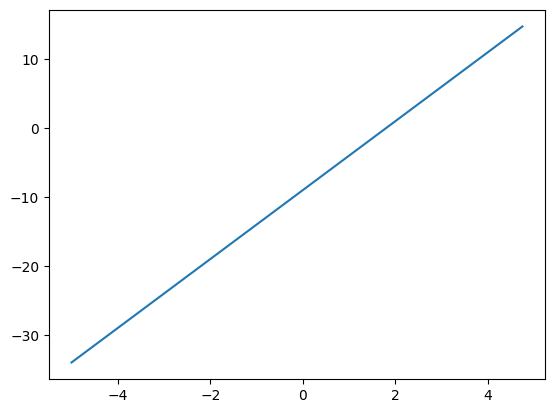

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def func(x):
    return 5*x -9

xs=np.arange(-5,5,0.25)
ys=func(xs)
plt.plot(xs, ys)

# Implementation of a Value in Neural Network

We are working on the Neural network which need to do backpropagation. So, we need to keep track of the children of a node, the `_prev` filed to the Value Type. We also have an op filed that shows how the Value was created.

In [3]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data=data
        self.label=label
        self._op=_op
        self._prev=set(_children)
        self.grad=0

    def __repr__(self):
        return f"Value=(data={self.data}, label={self.label})"
    
    def __add__(self, value):
        out=Value(self.data+value.data, (self, value), "+")
        return out
    
    def __mul__(self, value):
        out=Value(self.data*value.data, (self, value), "*")
        return out
        
# remember the neural network's formula Y=W*X+b
a=Value(2.0, label="a")
b=Value(-3.0,label="b")
c=Value(10.0, label="c")

e=a*b; e.label="e"
# d=a*b+c
d=e+c; d.label="d"

f=Value(-2.0, label='f')
# l=d*f
L=d*f; L.label='L'
L

Value=(data=-8.0, label=L)

# Visualizing Neural Network

we are goigng to use `graphviz` library to creating the describtion graph in DOT language.

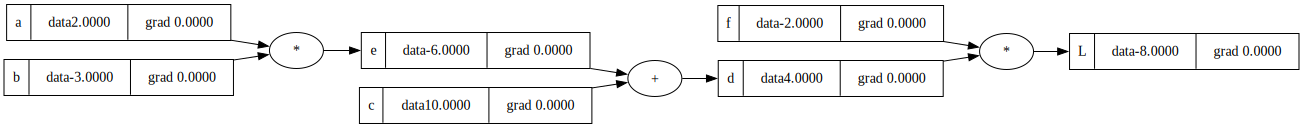

In [4]:
# Original code see the Acknowledge section
# Adapted by Aisuko
from graphviz import Digraph

def trace(root):
    nodes, edges=set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot=Digraph(format='png', graph_attr={'rankdir':'LR'}) # LR=left to right
    
    nodes, edges=trace(root)
    for n in nodes:
        uid=str(id(n))
        dot.node(name=uid, label="{%s|data%.4f|grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid+n._op, label=n._op)
            dot.edge(uid+n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2))+n2._op)
    return dot

# Plotting the variable L to layout the network. The _op nodes are just rendered to show the parent/child
# relation between nodes
draw_dot(L)

# Derivatives/Gradient

> Note: this part may does not clear. It needs model detail on how to calculating with chain rules.

Manually computing gradient, moving backward from $L$, which is the base case with a gradient of $1.0$. 

* We know that $L=d*f$, so gradient of L to f(rate of change of L to f can be written as $\frac{L_d}{f_d}$) is $d$ which means $d=\frac{L}{f}$ and gradient of L to d is  $f=\frac{L}{d}$.

* Since $d=e+c$ finding out rate of change of L to e, we can use chain rule $\frac{L_d}{e_d}=\frac{L_d}{d_d}*\frac{d_d}{e_d}$ => $\frac{L_d}{d_d}*\frac{e_d+c_d}{e_d}$ => $\frac{L_d}{d_d}*(1+\frac{c_d}{e_d})$.

* We got $e=a*b$, so $\frac{L_d}{a_d}=\frac{L_d}{e_d}*\frac{e_d}{a_d}$=>$\frac{L_d}{e_d}*b$


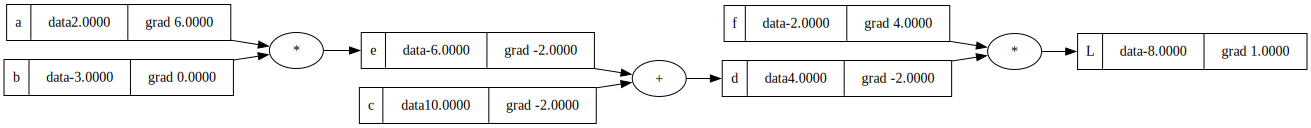

In [5]:
L.grad=1.0 #base case as rate of change of L wrt to L is 1

# gradient of L to d is f, to f is d. See describtion above.
d.grad=f.data
f.grad=d.data

e.grad=d.grad # L/e=L/d*d/e=L/d*(e+c)/e=L/d*(1+c/e)
c.grad=d.grad # same to above

a.grad=e.grad*b.data
b.grad-e.grad*a.data

draw_dot(L)

We can see that `+` nodes transfer gradients from child node to parent nodes. For example, the gradient of `e` and `c` are the same as that of `d(parent)`.

# Neuron

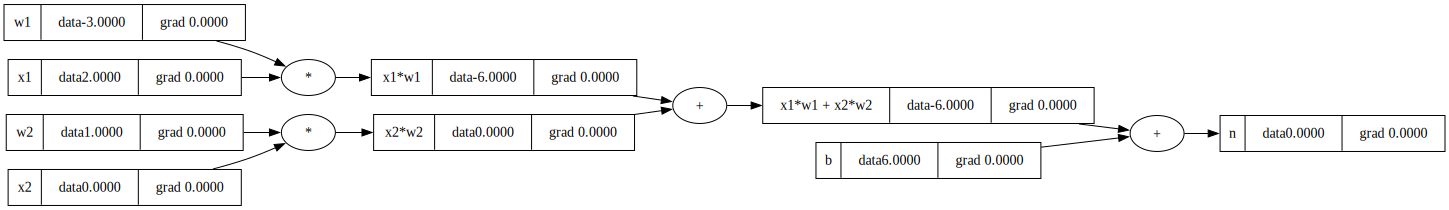

In [6]:
x1=Value(2.0, label='x1')
x2=Value(0.0, label='x2')

w1=Value(-3.0, label='w1')
w2=Value(1.0, label='w2')

b=Value(6, label='b')

x1w1=x1*w1; x1w1.label='x1*w1'
x2w2=x2*w2; x2w2.label='x2*w2'

x1w1x2w2=x1w1+x2w2; x1w1x2w2.label='x1*w1 + x2*w2'

n=x1w1x2w2+b; n.label='n'

draw_dot(n)

# Activation Function

Neurons also make use of something called an activation function. Activation functions introduce non-linearity into the neural network, allowing it to model complex relationships and learn from data. Here we are going to use `tanh` as our activation funciton. The tanh funciton squashes the net input, but it maps it to a range between -1 and 1. It is often used in hidden layers of neural networks. See notebook [Multilayer Dense Convolutional Neural Network](https://www.kaggle.com/code/aisuko/multilayer-dense-convolutional-neural-network) for illustration of the activation functions.

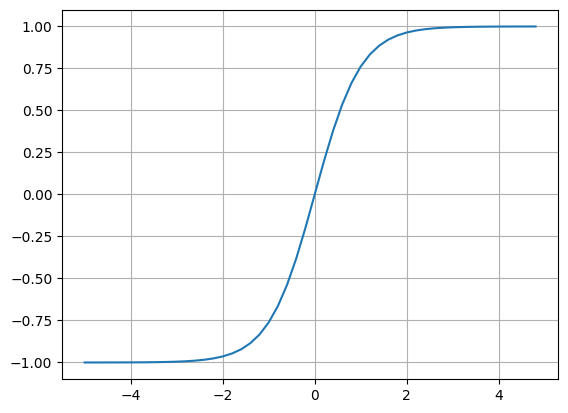

In [7]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
plt.grid()

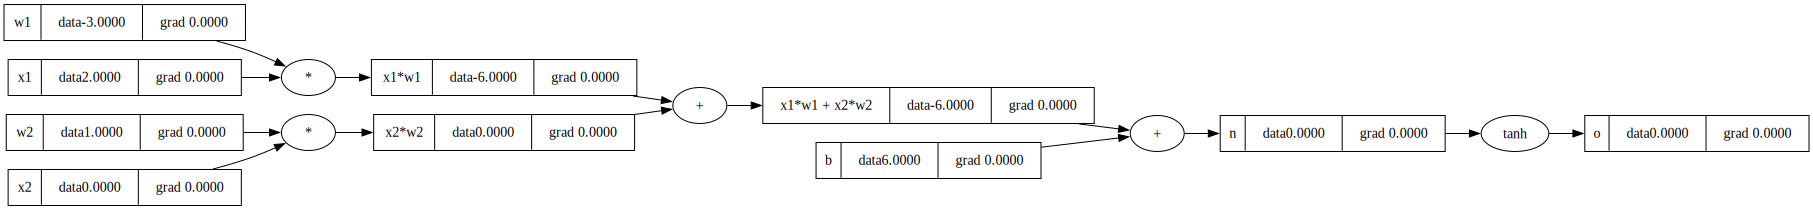

In [8]:
import math

def tanh(self):
    x=self.data
    t=(math.exp(2*x)-1)/(math.exp(2*x)+1)
    out=Value(t,(self,), 'tanh')
    return out

Value.tanh=tanh

o=n.tanh(); o.label='o'
draw_dot(o)

# Back-propagation

We want to calcualte the gradient to each note, it will be insanity to do that manually as the size of the network grows. We'd like to create a method `_backward` that does that for each node. Since calculating the gradient requires differentiating the function, we'd have to implement that in `_backward` method. Here's what that would look like for each operation in Value type.

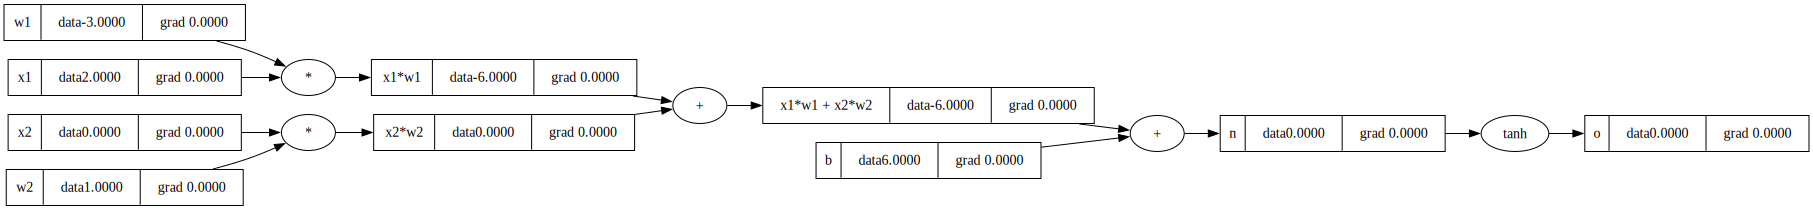

In [9]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data=data
        self.label=label
        self._op=_op
        self._prev=set(_children)
        self._backward=lambda: None
        self.grad=0.0

    def __repr__(self):
        return f"Value=(data={self.data}, label={self.label})"
    
    def __add__(self, value):
        out=Value(self.data+value.data, (self, value), "+")
        
        def _backward():
            self.grad+=1.0*out.grad
            value.grad+=1.0*out.grad
        out._backward=_backward()
        return out
    
    def __mul__(self, value):
        out=Value(self.data*value.data, (self, value), "*")
        
        def _backward():
            self.grad+=value.data*out.grad
            value.grad+=self.data*out.grad
        out._backward=_backward
        return out
    
    def tanh(self):
        x=self.data
        t=(math.exp(2*x)-1)/(math.exp(2*x)+1)
        out=Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad+=(1-t**2)*out.grad
        out._backward=_backward
        return out

x1=Value(2.0, label='x1')
x2=Value(0.0, label='x2')

w1=Value(-3.0, label='w1')
w2=Value(1.0, label='w2')

b=Value(6, label='b')

x1w1=x1*w1; x1w1.label='x1*w1'
x2w2=x2*w2; x2w2.label='x2*w2'

x1w1x2w2=x1w1+x2w2; x1w1x2w2.label='x1*w1 + x2*w2'

n=x1w1x2w2+b; n.label='n'
o=n.tanh(); o.label='o'

draw_dot(o)

# Acknowledge
* https://pub.towardsai.net/neural-network-from-scratch-6fa1e78a3515
* https://www.mathsisfun.com/calculus/derivatives-introduction.html
* https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/micrograd/micrograd_lecture_second_half_roughly.ipynb